# Truncated regression: minimum working example

In [1]:
import numpy as np
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

In [2]:
def pp_plot(x, y, trace):
    fig, ax = plt.subplots()
    # plot data
    ax.scatter(x, y)
    # plot posterior predicted... samples from posterior
    xi = np.array([np.min(x), np.max(x)])
    n_samples=100
    for n in range(n_samples):
        y_ppc = xi * trace["m"][n] + trace["c"][n]
        ax.plot(xi, y_ppc, "k", alpha=0.1, rasterized=True)
    # plot true
    ax.plot(xi, m * xi + c, "r", lw=3, label="True")
    # plot bounds
    ax.axhline(bounds[0], c='r', ls='--')
    ax.axhline(bounds[1], c='r', ls='--')

In [3]:
def truncate_y(x, y, bounds):
    keep = (y >= bounds[0]) & (y <= bounds[1])
    return (x[keep], y[keep])

In [4]:
m, c, σ, N = 1, 0, 2, 200
x = np.random.uniform(-10, 10, N)
y = np.random.normal(m * x + c, σ)
bounds = [-5, 5]

In [5]:
xt, yt = truncate_y(x, y, bounds)

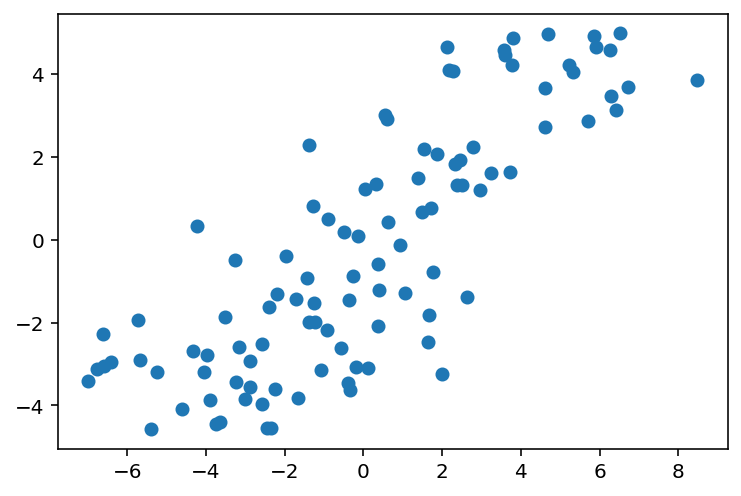

In [6]:
plt.scatter(xt, yt)

## Linear regression of truncated data underestimates the slope

In [7]:
def linear_regression(x, y):

    with pm.Model() as model:
        m = pm.Normal("m", mu=0, sd=1)
        c = pm.Normal("c", mu=0, sd=1)
        σ = pm.HalfNormal("σ", sd=1)
        y_likelihood = pm.Normal("y_likelihood", mu=m*x+c, sd=σ, observed=y)

    with model:
        trace = pm.sample()

    return model, trace

# run the model on the truncated data (xt, yt)
linear_model, linear_trace = linear_regression(xt, yt)

/Users/benjamv/opt/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, c, m]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


/Users/benjamv/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<AxesSubplot:title={'center':'m'}>

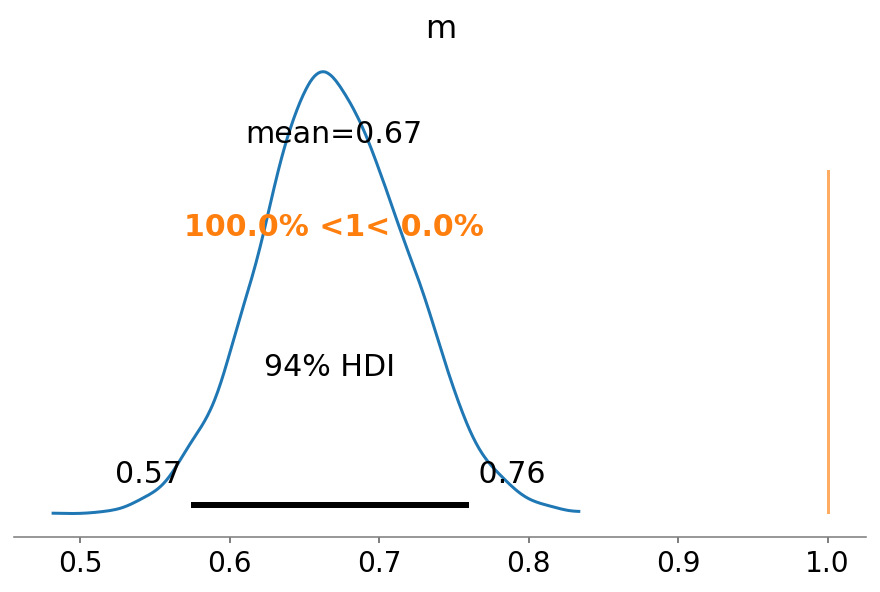

In [8]:
az.plot_posterior(linear_trace, var_names=['m'], ref_val=m)

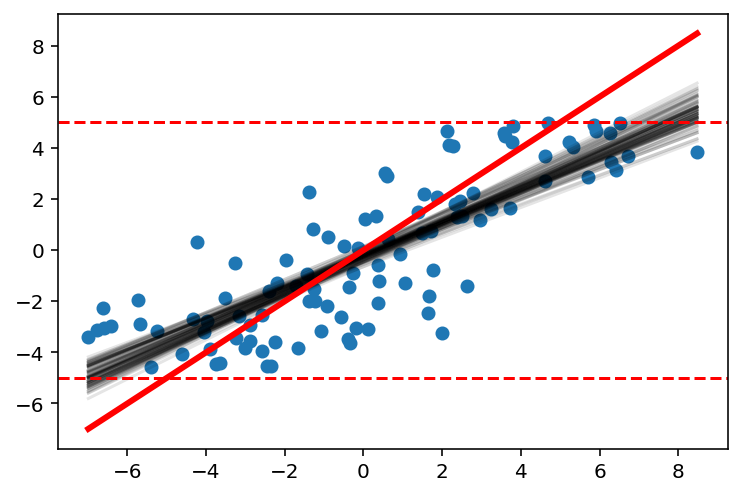

In [9]:
pp_plot(xt, yt, linear_trace)

## Truncated regression avoids this underestimate

In [10]:
def truncated_regression(x, y, bounds):

    with pm.Model() as model:
        m = pm.Normal("m", mu=0, sd=1)
        c = pm.Normal("c", mu=0, sd=1)
        σ = pm.HalfNormal("σ", sd=1)

        y_likelihood = pm.TruncatedNormal(
            "y_likelihood",
            mu=m * x + c,
            sd=σ,
            observed=y,
            lower=bounds[0],
            upper=bounds[1],
        )
    
    with model:
        trace = pm.sample()

    return model, trace


# run the model on the truncated data (xt, yt)
truncated_model, truncated_trace = truncated_regression(xt, yt, bounds)

WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tens

/Users/benjamv/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implement

<AxesSubplot:title={'center':'m'}>

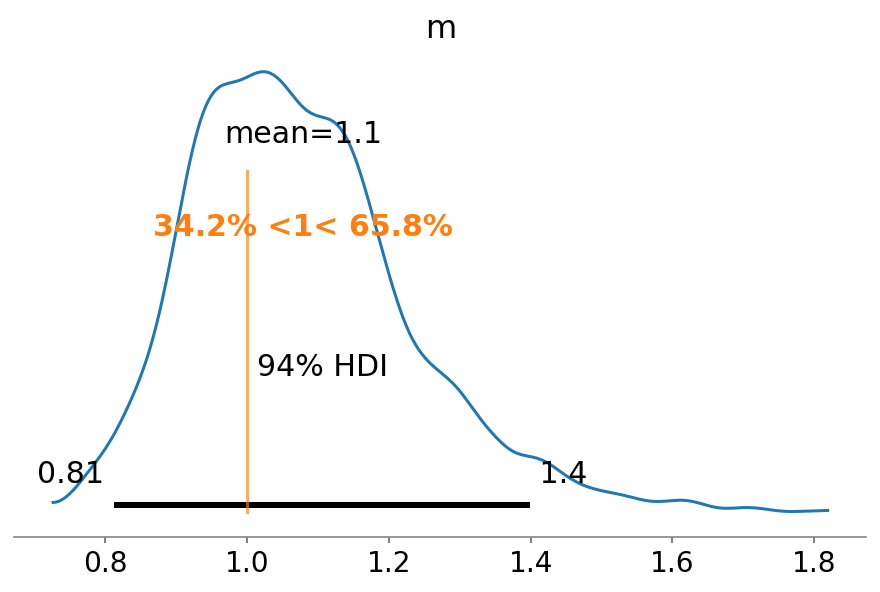

In [11]:
az.plot_posterior(truncated_trace, var_names=['m'], ref_val=m)

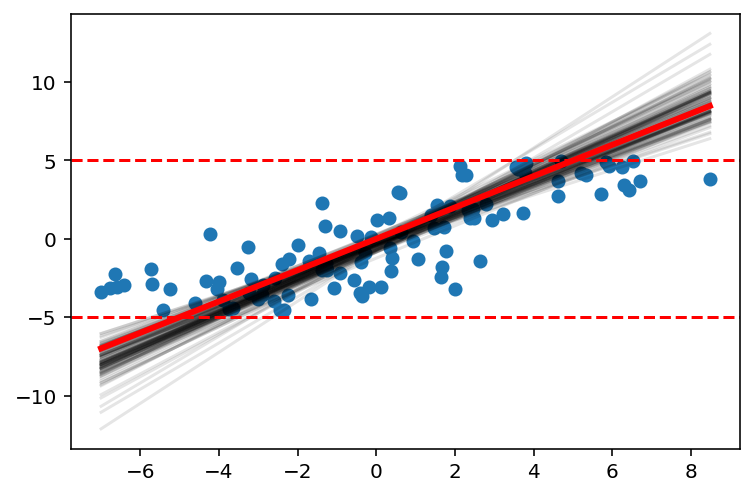

In [12]:
pp_plot(xt, yt, truncated_trace)

In [13]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Jan 24 2021

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

arviz     : 0.11.0
pymc3     : 3.10.0
numpy     : 1.19.2
matplotlib: 3.3.2

Watermark: 2.1.0

